In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Keras needed modules
models = tf.keras.models
layers = tf.keras.layers
initializers = tf.keras.initializers
regularizers = tf.keras.regularizers
optimizers = tf.keras.optimizers
losses = tf.keras.losses
metrics = tf.keras.metrics
preprocessing_image = tf.keras.preprocessing.image
callbacks = tf.keras.callbacks

In [3]:
def residual_block(input_tensor, filters, kernel_size, stage, strides=(2,2), reg=0.0, shortcut='identity'):
    bn_name = 'bn' + str(stage)
    conv_name = 'conv' + str(stage)
    relu_name = 'relu' + str(stage)
    merge_name = 'merge' + str(stage)
    
    ##
    # First convolution layer of the block
    x = layers.Convolution2D(
        filters,
        kernel_size,
        padding='same',
        strides = strides,
        kernel_regularizer = regularizers.l2(reg),
        use_bias = False,
        name = conv_name + 'a'
        )(input_tensor)
        
    # Batch normalizer layer
    x = layers.BatchNormalization(name = bn_name + 'a')(x)
    
    # Activation layer
    x = layers.Activation('relu', name = relu_name+'a')(x)
    # Second convolution layer of the block
    x = layers.Convolution2D(
        filters,
        kernel_size,
        padding='same',
        kernel_regularizer = regularizers.l2(reg),
        use_bias = False,
        name = conv_name + 'b'
        )(x)
        
    # Batch normalizer layer
    x = layers.BatchNormalization(name = bn_name + 'b')(x)
    # we need to make the shotcut connection
    if shortcut == 'identity':
        x = x # Identity
    
    else: # Shapes are not the same => conv 1x1
        input_tensor = layers.Convolution2D(
                        filters,
                        kernel_size,
                        padding='same',
                        strides = strides,
                        use_bias = False,
                        )(input_tensor)
    
    # Addition
    x = layers.add([x, input_tensor], name = merge_name)
        
    # Activation layer
    x = layers.Activation('relu', name = relu_name+'b')(x)
    
    ## We have reached the end of the block
    
    return x

In [4]:
def first_conv_layer(input_tensor, filters=32, kernel_size=(3,3), reg=0.0, conv_name='conv1'):
    # First convolution layer of the block
    x = layers.Convolution2D(
        filters,
        kernel_size,
        kernel_regularizer = regularizers.l2(reg),
        strides = (1,1),
        padding = 'same',
        use_bias = False,
        name = conv_name + '-conv'
        )(input_tensor)
    return x

In [5]:
def output_layer(input_tensor, nb_classes=10, pool_size=4):
    
    x = layers.AveragePooling2D((pool_size,pool_size),
                                name='avr_pool'
                                )(input_tensor)
    
    x = layers.Flatten(name = 'flat')(x)
    
    x = layers.Dense(nb_classes, activation='softmax', 
                     name='fc10')(x)
    
    return x

In [6]:
def Resnet_model(input_shape=(32,32,3), nb_classes=10, reg=0.0):
    
    # Input layer
    img_input = layers.Input(shape=input_shape)
    
    # Stage counter
    stage = 1
    
    ### Resnet 
    # First conv layer conv1
    x = first_conv_layer(img_input, filters=32, kernel_size=(3,3), reg=0.0)
    stage+=1
    
    ## First block
    # 3x3, 32: conv-batchNorm-relu
    # 3x3, 32: conv-batchNorm-relu
    x = residual_block(x, filters=32, kernel_size=(3,3), strides=(1,1), shortcut='identity',stage=stage, reg=reg)
    stage+=1
    
    ## First block 2
    # 3x3, 32: conv-batchNorm-relu
    # 3x3, 32: conv-batchNorm-relu
    x = residual_block(x, filters=32, kernel_size=(3,3), strides=(1,1), shortcut='identity', stage=stage, reg=reg)
    stage+=1
    
    ## Second block
    # 3x3, 64: conv-batchNorm-relu
    # 3x3, 64: conv-batchNorm-relu
    x = residual_block(x, filters=64, kernel_size=(3,3), shortcut='conv', stage=stage, reg=reg)
    stage+=1
    
    ## Second block 2
    # 3x3, 64: conv-batchNorm-relu
    # 3x3, 64: conv-batchNorm-relu
    x = residual_block(x, filters=64, kernel_size=(3,3), strides=(1,1), shortcut='identity', stage=stage, reg=reg)
    stage+=1
    
    ## Third block
    # 3x3, 128: conv-batchNorm-relu
    # 3x3, 128: conv-batchNorm-relu
    x = residual_block(x, filters=128, kernel_size=(3,3), shortcut='conv', stage=stage, reg=reg)
    stage+=1
    
    ## Third block 2
    # 3x3, 128: conv-batchNorm-relu
    # 3x3, 128: conv-batchNorm-relu
    x = residual_block(x, filters=128, kernel_size=(3,3), strides=(1,1), shortcut='identity', stage=stage, reg=reg)
    stage+=1
    
    ## Fourth block
    # 3x3, 256: conv-batchNorm-relu
    # 3x3, 256: conv-batchNorm-relu
    x = residual_block(x, filters=256, kernel_size=(3,3),  shortcut='conv', stage=stage, reg=reg)
    stage+=1
    
    ## Fourth block 2
    # 3x3, 256: conv-batchNorm-relu
    # 3x3, 256: conv-batchNorm-relu
    x = residual_block(x, filters=256, kernel_size=(3,3), strides=(1,1), shortcut='identity', stage=stage, reg=reg)
    stage+=1
    
    ## Output layer
    # avr_pool-10-d-fc-softmax
    x = output_layer(x, nb_classes, pool_size=x.get_shape()[-2])
    
    ## We have reached the end of the model. Let's return it
    
    return models.Model(img_input, x, name="ResNet_project")

# Let's check the model architecture
model = Resnet_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1-conv (Conv2D)             (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
conv2a (Conv2D)                 (None, 32, 32, 32)   9216        conv1-conv[0][0]                 
__________________________________________________________________________________________________
bn2a (BatchNormalization)       (None, 32, 32, 32)   128         conv2a[0][0]                     
__________________________________________________________________________________________________
relu2a (Ac

In [7]:
# Compiling the model
def compile_model(model):
    
    # Loss
    loss = losses.categorical_crossentropy
    
    # Optimizer
    optimizer = optimizers.SGD(lr=1e-4, momentum=0.9)
    
    # Metrics
    metric = [metrics.categorical_accuracy, metrics.top_k_categorical_accuracy]
    
    # Compile the model
    model.compile(optimizer, loss, metric)
    
    return model

In [8]:
# Image preprocessing and dataste Augmentation

# These operations are performed because the dataset is small

train_data_gen = preprocessing_image.ImageDataGenerator(
                    rescale = 1./255, # Normalizing the images [0,1]
                    shear_range = 0.1,
                    zoom_range = 0.1,
                    horizontal_flip = True) # Randomly flip the images

# For the test set, we need only to normalize the images
test_data_gen = preprocessing_image.ImageDataGenerator(rescale=1./255)

In [9]:
# Importing the dataset from Keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = to_categorical(y_train, 10)
y_test =  to_categorical(y_test , 10)

# Import data from the RAM
train_generator = train_data_gen.flow(x_train, y_train,
                                    batch_size = 32)

test_generator = test_data_gen.flow(x_test, y_test,
                                    batch_size = 32)

In [10]:
# Initializing the model
model = Resnet_model(input_shape=(32,32,3), nb_classes=10, reg=1e-4)

In [11]:
# Checkpoint callback to save training weights
checkpoint_path = "final_project_table1_data/cp.ckpt"
checkpoint_dir  = os.path.dirname(checkpoint_path)

# Creating checkpoint callback
cp_callback = callbacks.ModelCheckpoint(checkpoint_path,
                                       save_weights_only=True,
                                       verbose=1,
                                       period =5)

In [12]:
# Tensorboad callback to visualize the training performance
log_dir='final_project_table1_data/Graphs_table1'
tb_callback = callbacks.TensorBoard(log_dir=log_dir,
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_images=True)

In [13]:
# Compiling the model
model = compile_model(model)

In [14]:
# Try to restore model
try:
    model.load_weights(checkpoint_path)
    print("Model checkpoints found and successfully restored !")
except:
    print('Failed to load model weights')

Model checkpoints found and successfully restored !


In [15]:
# Training the built model
history = model.fit_generator(train_generator,
                   steps_per_epoch=100,
                   epochs=100,
                   validation_data=test_generator,
                   validation_steps=10,
                   callbacks=[tb_callback, cp_callback])

Epoch 1/100
100/100 [==============================] - 52s 518ms/step - loss: 0.7816 - categorical_accuracy: 0.7872 - top_k_categorical_accuracy: 0.9862 - val_loss: 1.1273 - val_categorical_accuracy: 0.6969 - val_top_k_categorical_accuracy: 0.9750
Epoch 2/100
100/100 [==============================] - 64s 643ms/step - loss: 0.7775 - categorical_accuracy: 0.7881 - top_k_categorical_accuracy: 0.9869 - val_loss: 0.9558 - val_categorical_accuracy: 0.7125 - val_top_k_categorical_accuracy: 0.9750
Epoch 3/100
100/100 [==============================] - 65s 654ms/step - loss: 0.7875 - categorical_accuracy: 0.7809 - top_k_categorical_accuracy: 0.9894 - val_loss: 1.0583 - val_categorical_accuracy: 0.7031 - val_top_k_categorical_accuracy: 0.9656
Epoch 4/100
100/100 [==============================] - 67s 669ms/step - loss: 0.7910 - categorical_accuracy: 0.7866 - top_k_categorical_accuracy: 0.9878 - val_loss: 0.9916 - val_categorical_accuracy: 0.7125 - val_top_k_categorical_accuracy: 0.9844
Epoch 5/

100/100 [==============================] - 114s 1s/step - loss: 0.7603 - categorical_accuracy: 0.8003 - top_k_categorical_accuracy: 0.9931 - val_loss: 0.9888 - val_categorical_accuracy: 0.7063 - val_top_k_categorical_accuracy: 0.9812
Epoch 25/100
 99/100 [============================>.] - ETA: 1s - loss: 0.7487 - categorical_accuracy: 0.7989 - top_k_categorical_accuracy: 0.9927
Epoch 00025: saving model to final_project_table1_data/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
100/100 [==============================] - 113s 1s/step - loss: 0.7497 - categorical_accuracy: 0.7984 - top_k_categorical_accuracy: 0.9928 - val_loss: 1.1038 - val_categorical_accuracy: 0.6906 - val_top_k_categorical_accuracy: 0.9688
Epoch 26/100
100/100 [==============================] - 115s 1s/step - loss: 0.7470 - categorical_accuracy: 0.7981 - top_k_categorical_accuracy: 0.9919 - val_loss: 0.9582 - val_categorical_accuracy: 0.7219 - val_top_k_categorical_accuracy: 0.9781
Epoch 27/100
100/10

Epoch 46/100
100/100 [==============================] - 113s 1s/step - loss: 0.7578 - categorical_accuracy: 0.7956 - top_k_categorical_accuracy: 0.9878 - val_loss: 1.0260 - val_categorical_accuracy: 0.7125 - val_top_k_categorical_accuracy: 0.9719
Epoch 47/100
100/100 [==============================] - 113s 1s/step - loss: 0.7411 - categorical_accuracy: 0.8063 - top_k_categorical_accuracy: 0.9916 - val_loss: 0.9610 - val_categorical_accuracy: 0.7250 - val_top_k_categorical_accuracy: 0.9656
Epoch 48/100
100/100 [==============================] - 114s 1s/step - loss: 0.7396 - categorical_accuracy: 0.8041 - top_k_categorical_accuracy: 0.9884 - val_loss: 0.9998 - val_categorical_accuracy: 0.7125 - val_top_k_categorical_accuracy: 0.9781
Epoch 49/100
100/100 [==============================] - 117s 1s/step - loss: 0.7211 - categorical_accuracy: 0.8175 - top_k_categorical_accuracy: 0.9891 - val_loss: 0.9423 - val_categorical_accuracy: 0.7375 - val_top_k_categorical_accuracy: 0.9812
Epoch 50/100

Epoch 70/100
 99/100 [============================>.] - ETA: 1s - loss: 0.7354 - categorical_accuracy: 0.8081 - top_k_categorical_accuracy: 0.9893
Epoch 00070: saving model to final_project_table1_data/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
100/100 [==============================] - 112s 1s/step - loss: 0.7343 - categorical_accuracy: 0.8084 - top_k_categorical_accuracy: 0.9894 - val_loss: 0.9161 - val_categorical_accuracy: 0.7281 - val_top_k_categorical_accuracy: 0.9719
Epoch 71/100
100/100 [==============================] - 113s 1s/step - loss: 0.7235 - categorical_accuracy: 0.8094 - top_k_categorical_accuracy: 0.9884 - val_loss: 1.0656 - val_categorical_accuracy: 0.7250 - val_top_k_categorical_accuracy: 0.9656
Epoch 72/100
100/100 [==============================] - 115s 1s/step - loss: 0.7326 - categorical_accuracy: 0.8097 - top_k_categorical_accuracy: 0.9938 - val_loss: 0.9005 - val_categorical_accuracy: 0.7531 - val_top_k_categorical_accuracy: 0.9719
Epoch 

100/100 [==============================] - 89s 886ms/step - loss: 0.7531 - categorical_accuracy: 0.7978 - top_k_categorical_accuracy: 0.9903 - val_loss: 0.8867 - val_categorical_accuracy: 0.7438 - val_top_k_categorical_accuracy: 0.9781
Epoch 92/100
100/100 [==============================] - 88s 883ms/step - loss: 0.7232 - categorical_accuracy: 0.8053 - top_k_categorical_accuracy: 0.9931 - val_loss: 0.9720 - val_categorical_accuracy: 0.7281 - val_top_k_categorical_accuracy: 0.9812
Epoch 93/100
100/100 [==============================] - 88s 885ms/step - loss: 0.7106 - categorical_accuracy: 0.8138 - top_k_categorical_accuracy: 0.9919 - val_loss: 0.9071 - val_categorical_accuracy: 0.7469 - val_top_k_categorical_accuracy: 0.9812
Epoch 94/100
100/100 [==============================] - 91s 914ms/step - loss: 0.7008 - categorical_accuracy: 0.8144 - top_k_categorical_accuracy: 0.9916 - val_loss: 0.8680 - val_categorical_accuracy: 0.7625 - val_top_k_categorical_accuracy: 0.9844
Epoch 95/100
 99/

In [16]:
# Plot the accuracy and loss over time
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize=(15, 10))
    
    # Plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('SqueezeNet Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.show()

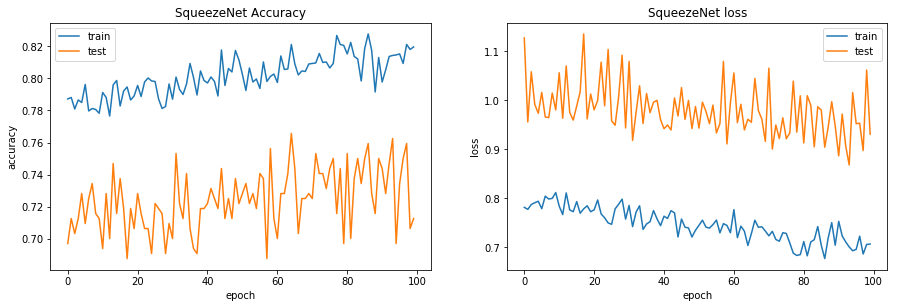

In [17]:
plot_accuracy_and_loss(history)

In [18]:
# Backup - Save model weights manually
#model_json = model.to_json()
#open('final_project_table1_model.json', 'w').write(model_json)

# Saving the model in h5 file format
model.save('final_project_table1_model.h5')

# save model's learned weights
model.save_weights('final_project_table1_weights.h5', overwrite=True)